# Sentiment Analysis with Natural Language Processing and Machine Learning 
##### Written by: Jordan Fortney

Language is one of the fundamental pillars of our society so it comes as no surprise that it can be an incredibly powerful form of data if it is processed and analyzed effectively. The ability to analyse every book in a library or every political article from the past decade is something that is only possible using computer science and opens up many powerful avenues to augment a decision making process. From product reviews to social media posts to novels and articles the mediums in which our language can be conveyed is diverse and complex. This diversity and complexity, along with the inherent nuances innately found in how we communicate, requires special techniques and strategies to be applied before it can be used to train machine learning models and make meaningful predictions. 

A common use for natural language processing (NLP) is to determine the overall sentiment regarding a specific subject. This subject could be anything from a product review to someone's tweet history. This project will outline those processing steps, test and compare various optimized machine learning models, and build a production ready tool that predicts the sentiment of product reviews and outputs a list with those predictions. 

## Project Set-up and Data Overview

### Packages:
A relatively standard suite of packages is used for thsi project but of note are the CountVectrorizer and TfidfVectorizer packages from [sklearn](https://scikit-learn.org/stable/about.html#citing-scikit-learn). These packages are used to tokenize text which is an intergral part of NLP.

In [12]:
# standard python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os.path
import time
from datetime import date

# nlp tokenizers and support packages
import nltk
import string
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# machine Learning models and tools 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# metrics used to determine the accuracy of the models and compare them
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# ignore some warnings that can be unsightly
import warnings
warnings.filterwarnings('ignore')

### Data Upload and Overview
The primary dataset used for this project is a generic dataset composed of text from Twitter, Yelp, and Mobile Reviews, it was downloaded from [Kaggle](https://www.kaggle.com/akgeni/generic-sentiment-multidomain-sentiment-dataset). The dataset has 3 features: sentiment (positive, negative, or neutral), text, and a numeric label (0, 1, 2). The sentiment and label feature are technically redundant as we can get the same information by only have one of the two.

In [13]:
# load csv from local repository
sentTrain = pd.read_csv('generic_sentiment_dataset_50k.csv')
# display the dataframe
display(sentTrain.head())
# dataframe shape (50000 rows, 3 features)
display(sentTrain.shape)

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,2
1,positive,Overall in hand ecpirience is quite good matt ...,2
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",2
3,positive,Bigger size of application names doesn't allow...,2
4,negative,Just a hype of stock android which is not flaw...,0


(50000, 3)

The distribution of the labels is unbalanced but not drastically so with a 50/30/20 split for a multi-class dataset. The degree in which the data is skewed does not require us to re-sample the data to ensure proper model training but SMOTE re-sampling would be the suggested method if if we wanted to go that route. Later in the project we will explore different distributions but the project will focus on training the model with 3 potential classes. 

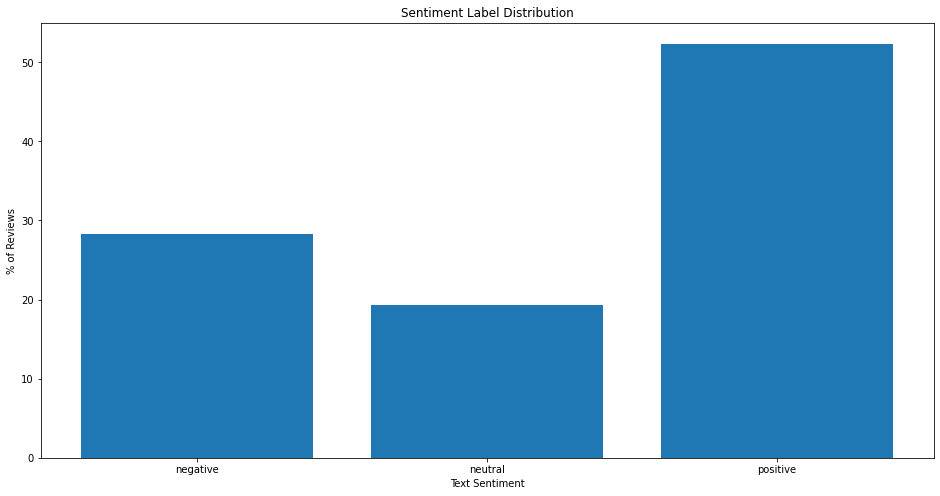

In [14]:
# get the unique values and their counts for the dataset
values, counts = np.unique(sentTrain['sentiment'], return_counts=True)
# normalize the counts to percentages
normalized_counts = counts/counts.sum()

# plot the unique sentiments and their normalized counts
plt.figure(figsize = (16,8))
plt.bar(values, normalized_counts*100)
plt.xlabel('Text Sentiment')
plt.xticks([0,1,2])
plt.ylabel('% of Reviews')
plt.title("Sentiment Label Distribution")
plt.show()

### Vectorization:

Vectorization is the process of processing a body of text and transforming it into a format that is more digestible by the model by creating 'token', removing transitional words, and ensuring common words are in a uniform tense structure. The tokens, which can be 1 word or more depending on the parameters, are turned into individual features in place of the original body of text. Another function of the vectorizer is to remove punctuation and transitional words (stop words) from the dataset such as: this, a, and, an. These words are removed because they offer no predictive information to the model and are also likely to be found in all potential classes. For example the phrases "This is good" or "This is bad" provides the same amount of useful information as "good" or "bad". Lastly the vectorizer will use stemming to ensure words are in a common root form. Words like: "worked", "works", and "working" will all be changed to "work" and aggregated.

The end product of vectorization is the creation of a feature for each token and an associated value for each token corresponding to what tokens are present in each record. There are two main forms for this value to take on that depends on which of the two main vectorizers are used. The Count Vecotrizer (bag of words) method returns a value equal to the count of each token within the specific record. The TF-IDF Vectorizer returns a value equal to the normalized weight of each token within the record which represents how relevant that token is within the record. Different models will perform differently using either vectorizer so we will use both on our dataset and test both within each model.


### Custom Tokenizer:
This project uses a custom tokenizer that I was given during on of my courses that removes all the common English stop words and performs stemming. We're using this because the standard tokenizers do not include stemming.

In [15]:
# provided to me during my Data Science diploma program

ENGLISH_STOP_WORDS = stopwords.words('english')

def customTokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    stemmer = nltk.stem.PorterStemmer()
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [33]:
# function to graph the frequencyt of each gram 

def plot_most_frequent(words, word_counts, top=20):
    # create a temp dataframe containing the words and their counts from the vectorizer
    wordsDF = pd.DataFrame({"token": words, "count": word_counts})
    wordsDF = wordsDF.sort_values(by = 'count', ascending = False).head(top)
    
    # plot the frequency of each gram and sort it in descending order
    plt.figure(figsize=(16,8))
    plt.bar(wordsDF['token'], wordsDF['count'])
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()

### Count Vectorizer:
The text feature from our dataset will be run through the Count Vectorizer a new dataset will be created to display the tokenization. Through its parameters the vectorizer will also exclude any token that does not occur more than 75 times (min_df = 75) and will create tokens consisting of 1 to 3 consecutive words (ngram_range = (1,3)).

In [17]:
# splitting the text and labels into their own variables
X = sentTrain['text']
y = sentTrain['label']

In [18]:
# prelaod the count vectorizer if it saved
if (os.path.exists('preRunModels/sentWordsVec.joblib')):
    sentWordsVec = joblib.load('preRunModels/sentWordsVec.joblib')
# run the count vectorizer if it has not been prerun
else:
    sentWordsVec = CountVectorizer(min_df = 75, 
                                   tokenizer = customTokenizer,
                                   strip_accents = 'ascii',
                                   ngram_range = (1,3),
                                   dtype = list)
    
    # save the model result lists for loading in the futrure
    joblib.dump(sentWordsVec, 'preRunModels/sentWordsVec.joblib')
    
# fit the text feature from the original dataset to the count vectorizer
sentWordsVec.fit(X)
# transform the text feature from the original dataset
X_Vec = sentWordsVec.transform(X)

In [19]:
# build a new dataframe for the count vectorized tokens
VecDF = pd.DataFrame(columns = sentWordsVec.get_feature_names(), data = X_Vec.toarray())
VecDF['label'] = y
display(VecDF)

,\r\n\r\ni,\r\n\r\nthe,0,1,1 day,1 month,10,10 day,100,10000,...,your,youtub,yummi,zoom,…,🇺🇸,🇺🇸 gopdeb,🇺🇸 gopdeb gopdeb,👍,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


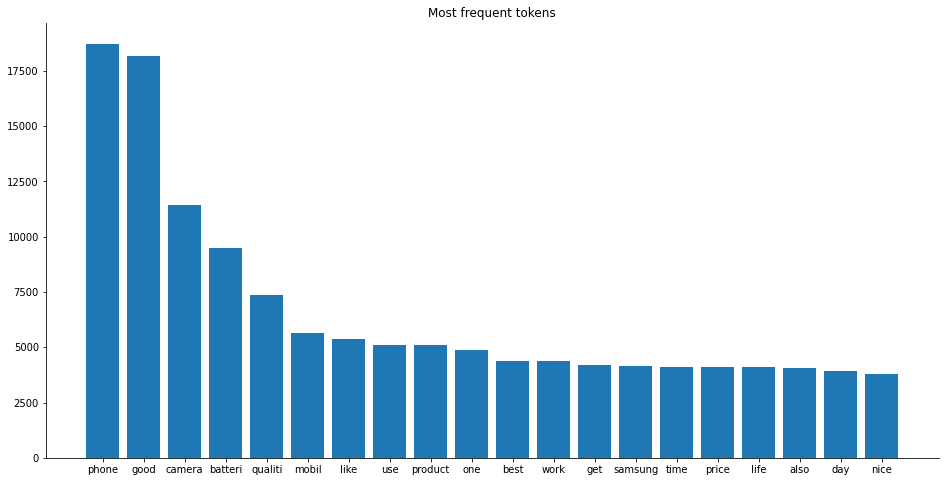

In [34]:
# sum the counts for each token
wordCountsVec = X_Vec.toarray().sum(axis=0)
# get the names of each token
wordsVec = sentWordsVec.get_feature_names()

# plot the counts and display the top 20 most frequent tokens
plot_most_frequent(wordsVec, wordCountsVec)

Based on the graph above it is very evident that the tokens: "phone" and "good" are prevalent throughout the dataset. The original dataset is based on data from Twitter, Yelp, and mobile reviews and with mobile reviews being the most specific of those three categories it is no surprise that the "phone" token is so prevalent.

### TF-IDF Vectorizer:
The text feature from our dataset will be run through the Count Vectorizer a new dataset will be created to display the tokenization. Through its parameters the vectorizer will also exclude any token that does not occur more than 75 times (min_df = 75) and will create tokens consisting of 1 to 3 consecutive words (ngram_range = (1,3)).

In [36]:
# prelaod the count vectorizer if it saved
if (os.path.exists('preRunModels/sentWordsIdf.joblib')):
    sentWordsIdf = joblib.load('preRunModels/sentWordsIdf.joblib')
# run the count vectorizer if it has not been prerun
else:
    sentWordsIdf = TfidfVectorizer(min_df = 75, 
                                   tokenizer = customTokenizer,
                                   ngram_range = (1,3),
                                   strip_accents = 'ascii',
                                   dtype = list)
    # save the model result lists for loading in the futrure
    joblib.dump(sentWordsIdf, 'preRunModels/sentWordsIdf.joblib')

# fit the text feature from the original dataset to the tf-idf vectorizer    
sentWordsIdf.fit(X)
# transform the text feature from the original dataset
X_Idf = sentWordsIdf.transform(X)

In [37]:
# build a new dataframe for the tf-idf vectorized tokens
IdfDF = pd.DataFrame(columns = sentWordsIdf.get_feature_names(), data = X_Idf.toarray())
IdfDF['label'] = y
display(IdfDF)

,\r\n\r\ni,\r\n\r\nthe,0,1,1 day,1 month,10,10 day,100,10000,...,year,yelp,yesterday,yet,youll,your,youtub,yummi,zoom,label
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.252649,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
49996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
49997,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


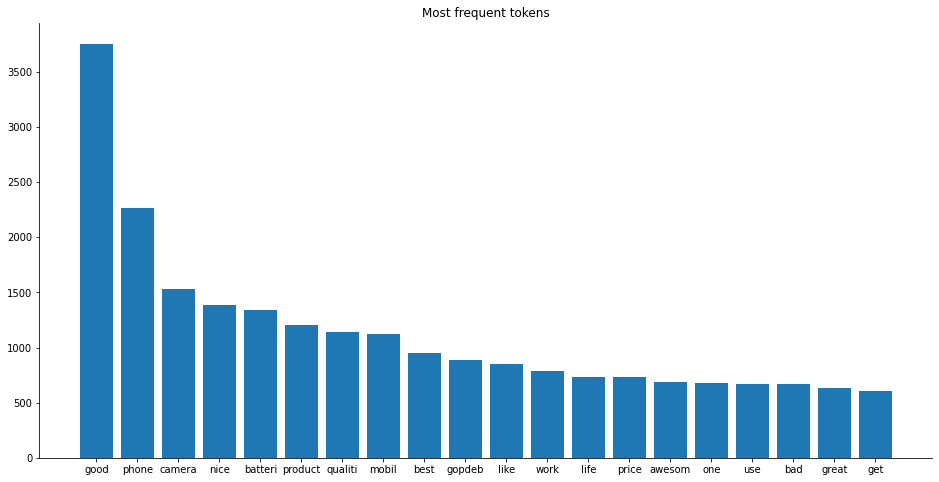

In [38]:
# sum the counts for each token
wordCountsIdf = X_Idf.toarray().sum(axis=0)
# get the names of each token
wordsIdf = sentWordsIdf.get_feature_names()

# plot the summed weights and display the top 20 most frequent tokens
plot_most_frequent(wordsIdf, wordCountsIdf)

The only significant change between the tf-idf vectorized tokens and those of the count vectorizer is that the "good" token dwarfs that of the "phone" token where they were almost equal before. This shows that although "phone" occurs more often, "good" holds much more weight within the records it doesn't occur in. Another notable difference is that "bad" comes into the top 20 tokens which should play a role in determining the sentiment of the record. 

## Machine Learning Models

Now that we have two sets of tokens we will build and optimize 5 different models for each vectorizer to determine which combonation will result in the best predictor. The models that will be tested are:

    * Logistic Regression
    * Support Vector Machine (SVC)
    * K-Nearest Neighbors
    * Decision Tree
    * Multinomial Naive Bayes


### Logistic Regression:

In [15]:
XVec = VecDF.iloc[:, :-1]
yVec = VecDF.iloc[:,-1]
print(f"Shapes: {XVec.shape, yVec.shape}")

Shapes: ((50000, 1650), (50000,))


In [16]:
X_trainVec, X_valVec, y_trainVec, y_valVec = train_test_split(XVec, yVec, test_size=0.33, random_state=12)
print(f"Train Shapes: {X_trainVec.shape, y_trainVec.shape}")
print(f"Val Shapes: {X_valVec.shape, y_valVec.shape}")

Train Shapes: ((33500, 1650), (33500,))
Val Shapes: ((16500, 1650), (16500,))


In [17]:
valScores = []
trainScores = []
cVals = []
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores.joblib') & os.path.exists('preRunModels/trainScores.joblib') & os.path.exists('preRunModels/cVals.joblib')):
    valScores = joblib.load('preRunModels/valScores.joblib')
    trainScores = joblib.load('preRunModels/trainScores.joblib')
    cVals = joblib.load('preRunModels/cVals.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        my_logreg = LogisticRegression(solver='lbfgs', C = c, random_state = 12)
        my_logreg.fit(X_trainVec, y_trainVec)

        trainScores.append(my_logreg.score(X_trainVec, y_trainVec))
        valScores.append(my_logreg.score(X_valVec, y_valVec))
        cVals.append(c)
    
        # Print progress through the loop
        print(f"C={c}", end="\r")
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores, 'preRunModels/valScores.joblib')
    joblib.dump(trainScores, 'preRunModels/trainScores.joblib')
    joblib.dump(cVals, 'preRunModels/cVals.joblib')
        
bestCValVec = cVals[np.argmax(valScores)]

Pre-run model will be loaded


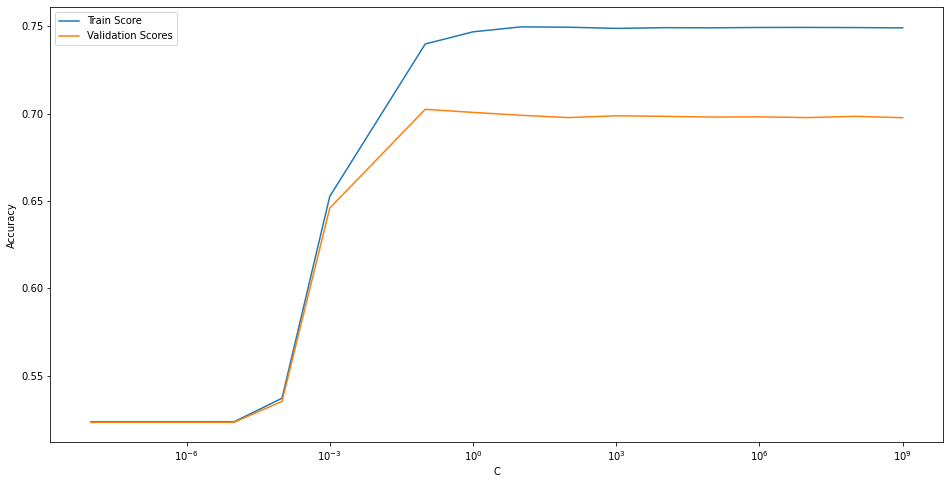

The c-calue with the highest validation score is 0.1


In [18]:
plt.figure(figsize = (16,8))
plt.plot(C_range, trainScores,label="Train Score")
plt.plot(C_range, valScores,label="Validation Scores")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-calue with the highest validation score is {bestCValVec}")

In [19]:
XIdf = IdfDF.iloc[:, :-1]
yIdf = IdfDF.iloc[:,-1]
print(f"Shapes: {XIdf.shape, yIdf.shape}")

Shapes: ((50000, 1647), (50000,))


In [20]:
X_trainIdf, X_valIdf, y_trainIdf, y_valIdf = train_test_split(XIdf, yIdf, test_size=0.33, random_state=12)
print(f"Train Shapes: {X_trainIdf.shape, y_trainIdf.shape}")
print(f"Val Shapes: {X_valIdf.shape, y_valIdf.shape}")

Train Shapes: ((33500, 1647), (33500,))
Val Shapes: ((16500, 1647), (16500,))


In [21]:
valScores2 = []
trainScores2 = []
cVals2 = []
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores2.joblib') & os.path.exists('preRunModels/trainScores2.joblib') & os.path.exists('preRunModels/cVals2.joblib')):
    valScores2 = joblib.load('preRunModels/valScores2.joblib')
    trainScores2 = joblib.load('preRunModels/trainScores2.joblib')
    cVals2 = joblib.load('preRunModels/cVals2.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        my_logreg = LogisticRegression(solver='lbfgs', C = c, random_state = 12)
        my_logreg.fit(X_trainIdf, y_trainIdf)

        trainScores2.append(my_logreg.score(X_trainIdf, y_trainIdf))
        valScores2.append(my_logreg.score(X_valIdf, y_valIdf))
        cVals2.append(c)
    
        # Print progress through the loop
        print(f"C={c}", end="\r")
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores2, 'preRunModels/valScores2.joblib')
    joblib.dump(trainScores2, 'preRunModels/trainScores2.joblib')
    joblib.dump(cVals2, 'preRunModels/cVals2.joblib')
        
bestCValIdf = cVals2[np.argmax(valScores2)]

Pre-run model will be loaded


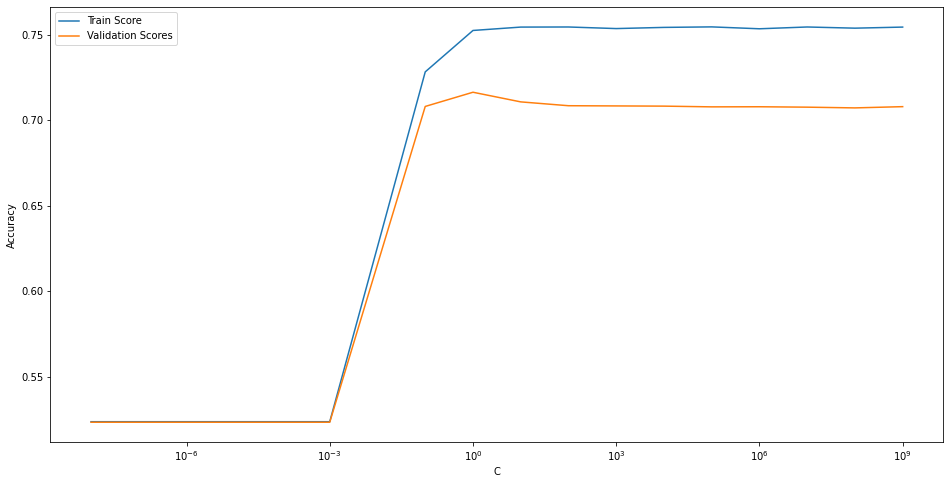

The c-calue with the highest validation score is 1.0


In [22]:
plt.figure(figsize = (16,8))
plt.plot(C_range, trainScores2, label="Train Score")
plt.plot(C_range, valScores2, label="Validation Scores")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-calue with the highest validation score is {bestCValIdf}")

In [23]:
logitVec = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)

if (os.path.exists('preRunModels/logitVec.joblib')):
    logitVec = joblib.load('preRunModels/logitVec.joblib')
    print("Pre-run model will be loaded")
else:
    logitVec = logitVec.fit(X_trainVec, y_trainVec)
    joblib.dump(logitVec, 'preRunModels/logitVec.joblib')


print(f"Logestical Regression Vec Train: {logitVec.score(X_trainVec, y_trainVec)}")
print(f"Logestical Regression Vec Validation: {logitVec.score(X_valVec, y_valVec)}")

Pre-run model will be loaded
Logestical Regression Vec Train: 0.7398805970149254
Logestical Regression Vec Validation: 0.7024848484848485


In [24]:

logitIdf = LogisticRegression(solver='lbfgs', C = bestCValIdf, random_state = 12)
if (os.path.exists('preRunModels/logitIdf.joblib')):
    logitIdf = joblib.load('preRunModels/logitIdf.joblib')
    print("Pre-run model will be loaded")
else:
    logitIdf = logitIdf.fit(X_trainIdf, y_trainIdf)
    joblib.dump(logitIdf, 'preRunModels/logitIdf.joblib')

print(f"Logestical Regression IDF Train: {logitIdf.score(X_trainIdf, y_trainIdf)}")
print(f"Logestical Regression IDF Validation: {logitIdf.score(X_valIdf, y_valIdf)}")

Pre-run model will be loaded
Logestical Regression IDF Train: 0.7523880597014926
Logestical Regression IDF Validation: 0.7163636363636363


## Vec C-Value

In [25]:
valScores3 = []
trainScores3 = []
cVals3 = []
C_range = np.array([0.1,1,10,100])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores3.joblib') & os.path.exists('preRunModels/trainScores3.joblib') & os.path.exists('preRunModels/cVals3.joblib')):
    valScores3 = joblib.load('preRunModels/valScores3.joblib')
    trainScores3 = joblib.load('preRunModels/trainScores3.joblib')
    cVals3 = joblib.load('preRunModels/cVals3.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        # Print progress through the loop
        print(f"C={c}", end="\r")
        
        svcVec = SVC(C = c, random_state = 12)
        svcVec.fit(X_trainVec, y_trainVec)

        trainScores3.append(svcVec.score(X_trainVec, y_trainVec))
        valScores3.append(svcVec.score(X_valVec, y_valVec))
        cVals3.append(c)
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores3, 'preRunModels/valScores3.joblib')
    joblib.dump(trainScores3, 'preRunModels/trainScores3.joblib')
    joblib.dump(cVals3, 'preRunModels/cVals3.joblib')
        
bestCValVecSvc = cVals3[np.argmax(valScores3)]

Pre-run model will be loaded


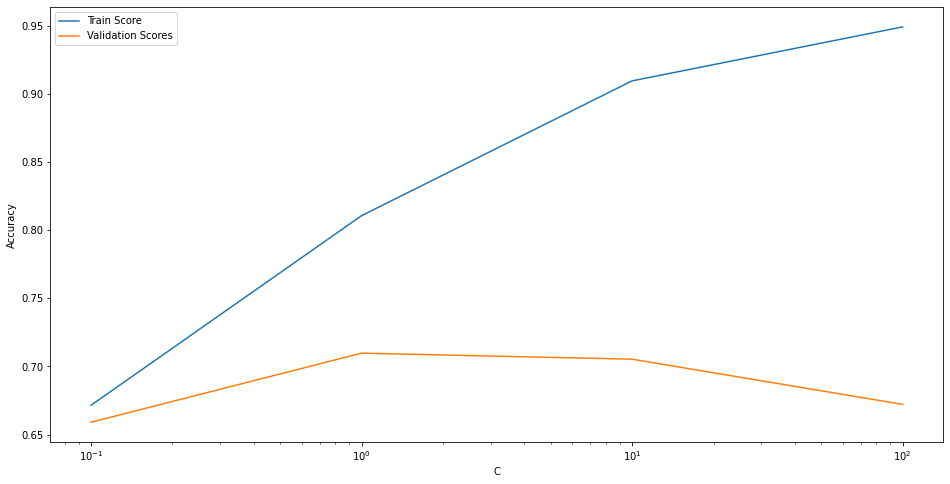

The c-value with the highest validation score is 1.0


In [26]:
plt.figure(figsize = (16,8))
plt.plot(C_range, trainScores3, label="Train Score")
plt.plot(C_range, valScores3, label="Validation Scores")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-value with the highest validation score is {bestCValVecSvc}")

## IDF C-Value

In [27]:
valScores31 = []
trainScores31 = []
cVals31 = []
C_range = np.array([0.1,1,10,100])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores3.joblib') & 
    os.path.exists('preRunModels/trainScores31.joblib') & 
    os.path.exists('preRunModels/cVals3.joblib')):
    valScores31 = joblib.load('preRunModels/valScores31.joblib')
    trainScores31 = joblib.load('preRunModels/trainScores31.joblib')
    cVals31 = joblib.load('preRunModels/cVals31.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        # Print progress through the loop
        print(f"C={c}", end="\r")
        
        svcIdf = SVC(C = c, random_state = 12)
        svcIdf.fit(X_trainIdf, y_trainIdf)

        trainScores31.append(svcIdf.score(X_trainIdf, y_trainIdf))
        valScores31.append(svcIdf.score(X_valIdf, y_valIdf))
        cVals31.append(c)
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores31, 'preRunModels/valScores31.joblib')
    joblib.dump(trainScores31, 'preRunModels/trainScores31.joblib')
    joblib.dump(cVals31, 'preRunModels/cVals31.joblib')
        
bestCValIdfSvc = cVals31[np.argmax(valScores31)]

Pre-run model will be loaded


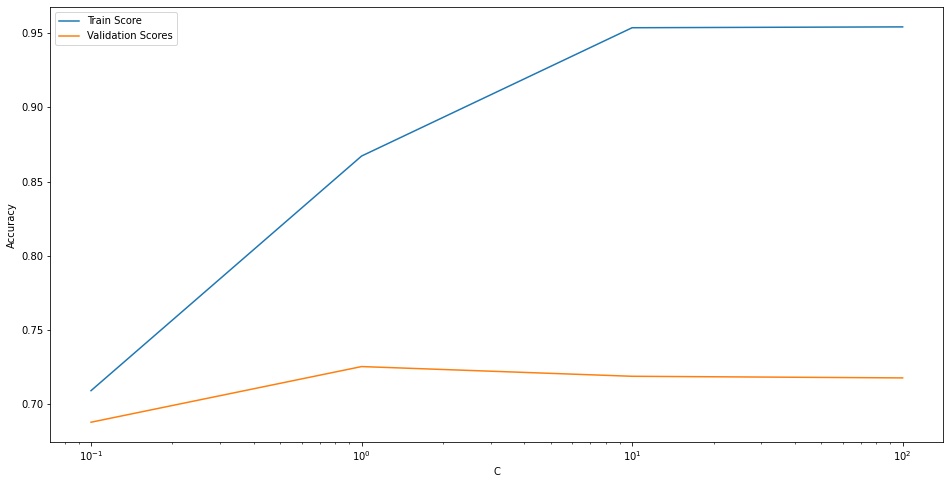

The c-value with the highest validation score is 1.0


In [28]:
plt.figure(figsize = (16,8))
plt.plot(C_range, trainScores31, label="Train Score")
plt.plot(C_range, valScores31, label="Validation Scores")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-value with the highest validation score is {bestCValIdfSvc}")

## SVC Models

In [29]:
svcVecNlp = SVC(C = bestCValVecSvc, random_state = 12)
if os.path.exists('preRunModels/svcVecNlp.joblib'):
    svcVecNlp = joblib.load('preRunModels/svcVecNlp.joblib')
else:
    svcVecNlp = svcVecNlp.fit(X_trainVec, y_trainVec)
    joblib.dump(svcVecNlp, 'preRunModels/svcVecNlp.joblib')

if os.path.exists('preRunModels/svcVecNlpTrainScore.joblib'):
    svcVecNlpTrainScore = joblib.load('preRunModels/svcVecNlpTrainScore.joblib')
else:
    svcVecNlpTrainScore = svcVecNlp.score(X_trainVec, y_trainVec)
    joblib.dump(svcVecNlpTrainScore, 'preRunModels/svcVecNlpTrainScore.joblib')

if os.path.exists('preRunModels/svcVecNlpValScore.joblib'):
    svcVecNlpValScore = joblib.load('preRunModels/svcVecNlpValScore.joblib')
else:
    svcVecNlpValScore = svcVecNlp.score(X_valVec, y_valVec)
    joblib.dump(svcVecNlpValScore, 'preRunModels/svcVecNlpValScore.joblib')

print(f"SVC Vec Train: {svcVecNlpTrainScore}")
print(f"SVC Vec Validation: {svcVecNlpValScore}",end= "\n")

print()

svcIdfNlp = SVC(C = bestCValIdfSvc, random_state = 12)
if os.path.exists('preRunModels/svcIdfNlp.joblib'):
    svcIdfNlp = joblib.load('preRunModels/svcIdfNlp.joblib')
else:
    svcIdfNlp = svcIdfNlp.fit(X_trainIdf, y_trainIdf)
    joblib.dump(svcIdfNlp, 'preRunModels/svcIdfNlp.joblib')

if os.path.exists('preRunModels/svcIdfNlpTrainScore.joblib'):
    svcIdfNlpTrainScore = joblib.load('preRunModels/svcIdfNlpTrainScore.joblib')
else:
    svcIdfNlpTrainScore = svcIdfNlp.score(X_trainIdf, y_trainIdf)
    joblib.dump(svcIdfNlpTrainScore, 'preRunModels/svcIdfNlpTrainScore.joblib')

if os.path.exists('preRunModels/svcIdfNlpValScore.joblib'):
    svcIdfNlpValScore = joblib.load('preRunModels/svcIdfNlpValScore.joblib')
else:
    svcIdfNlpValScore = svcIdfNlp.score(X_valIdf, y_valIdf)
    joblib.dump(svcIdfNlpValScore, 'preRunModels/svcIdfNlpValScore.joblib')

print(f"SVC IDF Train: {svcIdfNlpTrainScore}")
print(f"SVC IDF Validation: {svcIdfNlpValScore}")

SVC Vec Train: 0.8105970149253732
SVC Vec Validation: 0.7097575757575758

SVC IDF Train: 0.8672238805970149
SVC IDF Validation: 0.7253333333333334


## Vec K-Values broad

In [30]:
# Empty lists to store iteration results
valScores4 = []
trainScores4 = []
K_values4 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores4.joblib') & 
    os.path.exists('preRunModels/valScores4.joblib') & 
    os.path.exists('preRunModels/kValues4.joblib')):
    trainScores4 = joblib.load('preRunModels/trainScores4.joblib')
    valScores4 = joblib.load('preRunModels/valScores4.joblib')
    K_values4 = joblib.load('preRunModels/kValues4.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1, 10000, 100):

        # Train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainVec, y_trainVec)

        # Save model predictions and the relative number of neighbors to lists
        trainScores4.append(knnVec.score(X_trainVec, y_trainVec))
        valScores4.append(knnVec.score(X_valVec, y_valVec))
        K_values4.append(k)

    # Save the model result lists for loading in the futrure
    joblib.dump(trainScores4, 'preRunModels/trainScores4.joblib')
    joblib.dump(valScores4, 'preRunModels/valScores4.joblib')
    joblib.dump(K_values4, 'preRunModels/kValues4.joblib')
    
bestKValVecKnn = K_values4[np.argmax(valScores4)]

Pre-run model will be loaded


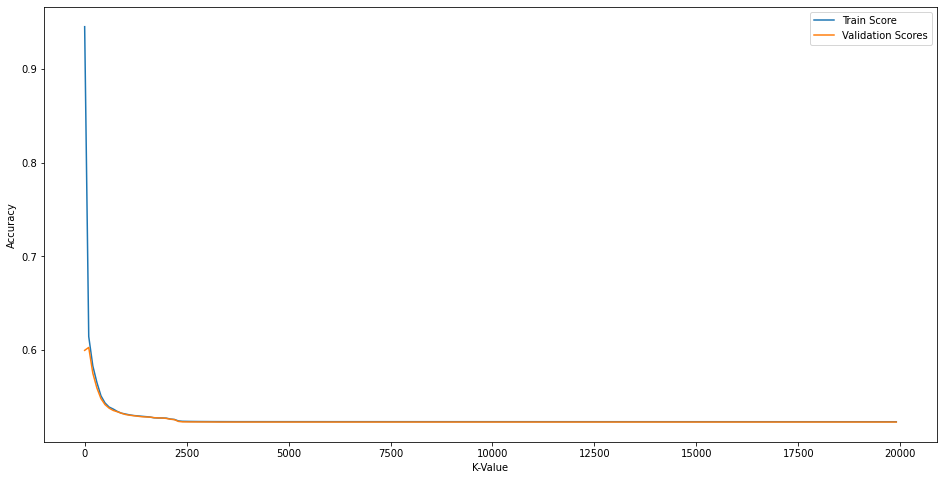

The K-Value with the highest validation score is 101


In [31]:
plt.figure(figsize = (16,8))
plt.plot(K_values4, trainScores4, label="Train Score")
plt.plot(K_values4, valScores4, label="Validation Scores")
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValVecKnn}")

## Vec K-Values narrow

In [32]:
# Empty lists to store iteration results
valScores5 = []
trainScores5 = []
K_values5 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores5.joblib') & 
    os.path.exists('preRunModels/valScores5.joblib') & 
    os.path.exists('preRunModels/k_Values5.joblib')):
    trainScores5 = joblib.load('preRunModels/trainScores5.joblib')
    valScores5 = joblib.load('preRunModels/valScores5.joblib')
    K_values5 = joblib.load('preRunModels/K_values5.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1,120):

        # Train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainVec, y_trainVec)

        # Train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainVec, y_trainVec)

        # Save model predictions and the relative number of neighbors to lists
        trainScores5.append(knnVec.score(X_trainVec, y_trainVec))
        valScores5.append(knnVec.score(X_valVec, y_valVec))
        Kvalues5.append(k)
    
    # Save the model result lists for loading in the futrure
    joblib.dump(trainScores5, 'preRunModels/trainScores5.joblib')
    joblib.dump(valScores5, 'preRunModels/valScores5.joblib')
    joblib.dump(K_values5, 'preRunModels/K_values5.joblib')
    
bestKValVecKnn = K_values5[np.argmax(valScores5)]

Pre-run model will be loaded


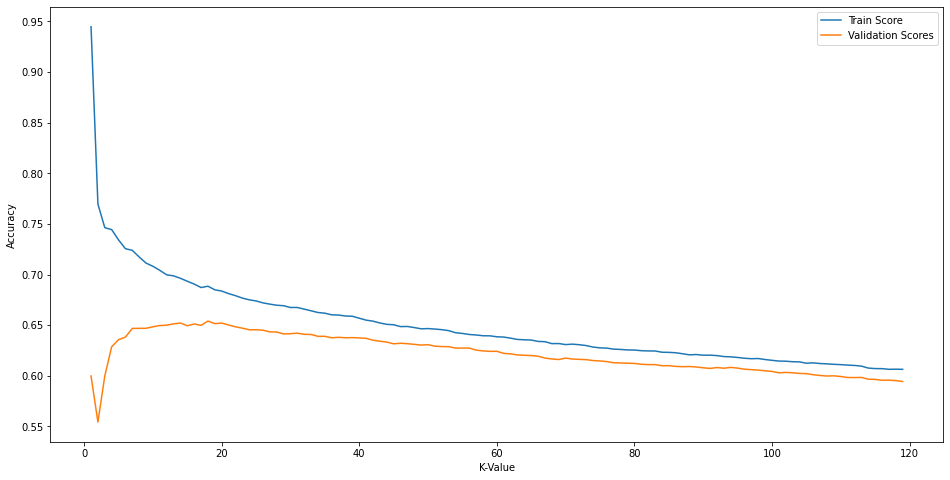

The K-Value with the highest validation score is 18


In [33]:
plt.figure(figsize = (16,8))
plt.plot(K_values5, trainScores5, label="Train Score")
plt.plot(K_values5, valScores5, label="Validation Scores")
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValVecKnn}")

## IDF K-Values broad

In [34]:
# Empty lists to store iteration results
trainScores41 = []
valScores41 = []
K_values41 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores41.joblib') & 
    os.path.exists('preRunModels/valScores41.joblib') & 
    os.path.exists('preRunModels/k_Values41.joblib')):
    trainScores41 = joblib.load('preRunModels/trainScores41.joblib')
    valScores41 = joblib.load('preRunModels/valScores41.joblib')
    K_values41 = joblib.load('preRunModels/k_Values41.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1, 10000, 100):

        # Train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainIdf, y_trainIdf)

        # Save model predictions and the relative number of neighbors to lists
        trainScores41.append(knnVec.score(X_trainIdf, y_trainIdf))
        valScores41.append(knnVec.score(X_valIdf, y_valIdf))
        K_values41.append(k)

    # Save the model result lists for loading in the futrure
    joblib.dump(trainScores41, 'preRunModels/trainScores41.joblib')
    joblib.dump(valScores41, 'preRunModels/valScores41.joblib')
    joblib.dump(K_values41, 'preRunModels/k_Values41.joblib')
    
bestKValIdfKnn = K_values41[np.argmax(valScores41)]

Pre-run model will be loaded


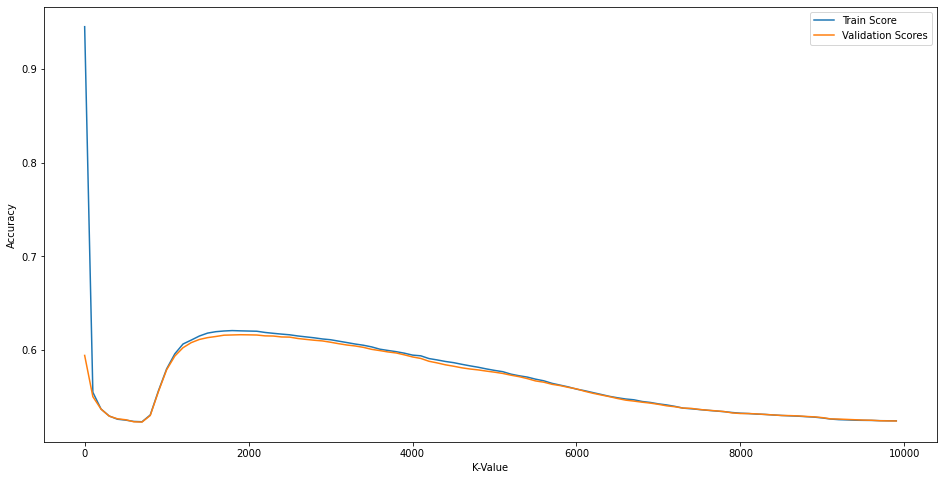

The K-Value with the highest validation score is 1901


In [35]:
plt.figure(figsize = (16,8))
plt.plot(K_values41, trainScores41, label="Train Score")
plt.plot(K_values41, valScores41, label="Validation Scores")
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValIdfKnn}")

## IDF K-Values narrow

In [36]:
# Empty lists to store iteration results
trainScores51 = []
valScores51 = []
K_values51 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores51.joblib') & 
    os.path.exists('preRunModels/valScores51.joblib') & 
    os.path.exists('preRunModels/K_values51.joblib')):
    trainScores51 = joblib.load('preRunModels/trainScores51.joblib')
    valScores51 = joblib.load('preRunModels/valScores51.joblib')
    K_values51 = joblib.load('preRunModels/K_values51.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1800, 2000):
        print(f"K={k}")
        # Train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainIdf, y_trainIdf)

        # Save model predictions and the relative number of neighbors to lists
        trainScores51.append(knnVec.score(X_trainIdf, y_trainIdf))
        valScores51.append(knnVec.score(X_valIdf, y_valIdf))
        K_values51.append(k)

    # Save the model result lists for loading in the futrure
    joblib.dump(trainScores51, 'preRunModels/trainScores51.joblib')
    joblib.dump(valScores51, 'preRunModels/valScores51.joblib')
    joblib.dump(K_values51, 'preRunModels/K_values51.joblib')
    
bestKValIdfKnn = K_values51[np.argmax(valScores51)]

Pre-run model will be loaded


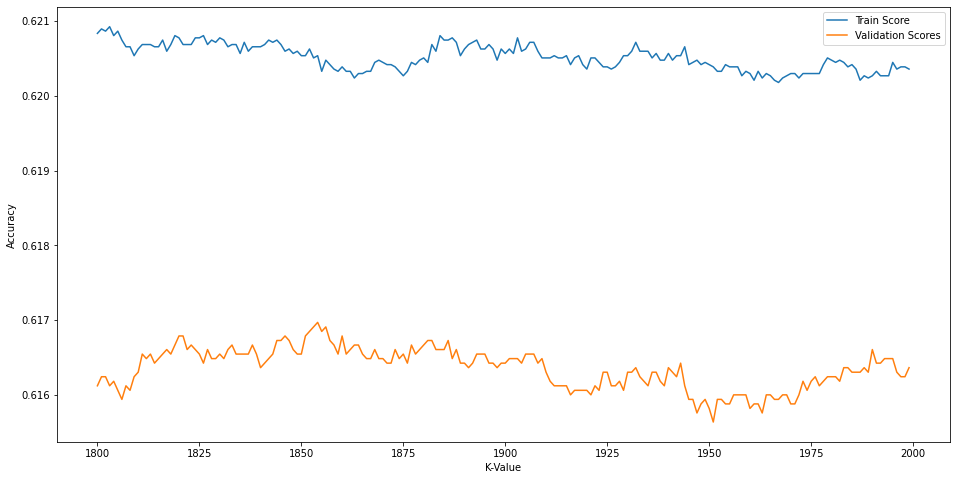

The K-Value with the highest validation score is 1854


In [37]:
plt.figure(figsize = (16,8))
plt.plot(K_values51, trainScores51, label="Train Score")
plt.plot(K_values51, valScores51, label="Validation Scores")
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValIdfKnn}")

## KNN Models

In [38]:
knnVecNlp = KNeighborsClassifier(n_neighbors=bestKValVecKnn).fit(X_trainVec, y_trainVec)
svcVecNlpTrainScore = knnVecNlp.score(X_trainVec, y_trainVec)
svcVecNlpValScore = knnVecNlp.score(X_valVec, y_valVec)

print(f"KNN Vec Train: {svcVecNlpTrainScore}")
print(f"KNN Vec Validation: {svcVecNlpValScore}")
print()

knnIdfNlp = KNeighborsClassifier(n_neighbors=bestKValIdfKnn).fit(X_trainIdf, y_trainIdf)
svcIdfNlpTrainScore = knnIdfNlp.score(X_trainIdf, y_trainIdf)
svcIdfNlpValScore = knnIdfNlp.score(X_valIdf, y_valIdf)

print(f"KNN IDF Train: {svcIdfNlpTrainScore}")
print(f"KNN IDF Validation: {svcIdfNlpValScore}")

KNN Vec Train: 0.6884776119402986
KNN Vec Validation: 0.654060606060606

KNN IDF Train: 0.6205373134328358
KNN IDF Validation: 0.616969696969697


## Vec Min Values

In [39]:
# Range to loop through from 1-20000
minSamples = np.arange(1, 125)
# Empty lists to store results for graphing
trainScores6 = []
valScores6 = []
min_value6 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores6.joblib') & 
    os.path.exists('preRunModels/valScores6.joblib') & 
    os.path.exists('preRunModels/min_value6.joblib')):
    trainScores6 = joblib.load('preRunModels/trainScores6.joblib')
    valScores6 = joblib.load('preRunModels/valScores6.joblib')
    min_value6 = joblib.load('preRunModels/min_value6.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-20000....
    for minS in minSamples:
        # Compile, train, and fit the model and data
        dtVec = DecisionTreeClassifier(min_samples_leaf = minS, random_state=12)
        dtVec.fit(X_trainVec, y_trainVec)

        trainScores6.append(dtVec.score(X_trainVec, y_trainVec))
        valScores6.append(dtVec.score(X_valVec, y_valVec))
        min_value6.append(minS)
        
        # Print the progress of the loop
        print(f"min samples={minS}")
        
    # SAve teh results lists to file
    joblib.dump(trainScores6, 'preRunModels/trainScores6.joblib')
    joblib.dump(valScores6, 'preRunModels/valScores6.joblib')
    joblib.dump(min_value6, 'preRunModels/min_value6.joblib')
    
bestMinValVecDt = min_value6[np.argmax(valScores6)]

Pre-run model will be loaded


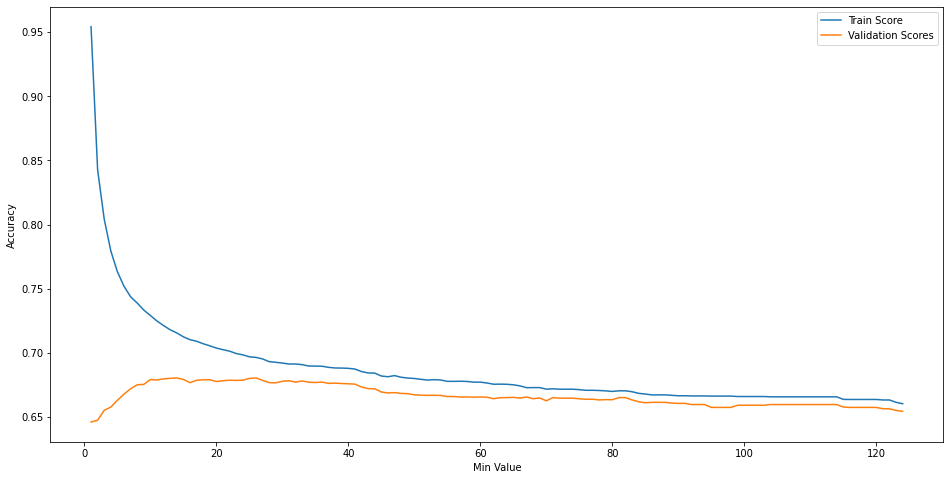

The Min Value with the highest validation score is 14


In [40]:
plt.figure(figsize = (16,8))
plt.plot(min_value6, trainScores6, label="Train Score")
plt.plot(min_value6, valScores6, label="Validation Scores")
plt.xlabel('Min Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Min Value with the highest validation score is {bestMinValVecDt}")

## IDF Min Values

In [41]:
# Range to loop through from 1-20000
minSamples = np.arange(1, 200)
# Empty lists to store results for graphing
trainScores61 = []
valScores61 = []
min_value61 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores61.joblib') & 
    os.path.exists('preRunModels/valScores61.joblib') & 
    os.path.exists('preRunModels/min_value61.joblib')):
    trainScores61 = joblib.load('preRunModels/trainScores61.joblib')
    valScores61 = joblib.load('preRunModels/valScores61.joblib')
    min_value61 = joblib.load('preRunModels/min_value61.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-20000....
    for minS in minSamples:
        # Compile, train, and fit the model and data
        dtIdf = DecisionTreeClassifier(min_samples_leaf = minS, random_state=12)
        dtIdf.fit(X_trainIdf, y_trainIdf)

        # Score the model predictions
        trainScores61.append(dtIdf.score(X_trainIdf, y_trainIdf))
        valScores61.append(dtIdf.score(X_valIdf, y_valIdf))
        min_value61.append(minS)
        
        # Print the progress of the loop
        print(f"min samples={minS}")
        
    # SAve teh results lists to file
    joblib.dump(trainScores61, 'preRunModels/trainScores61.joblib')
    joblib.dump(valScores61, 'preRunModels/valScores61.joblib')
    joblib.dump(min_value61, 'preRunModels/min_value61.joblib')
    
bestMinValIdfDt = min_value61[np.argmax(valScores61)]

Pre-run model will be loaded


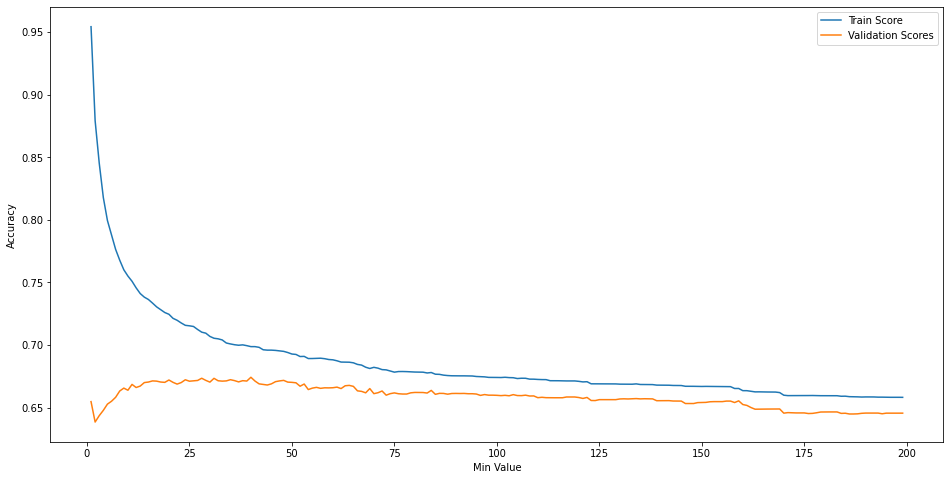

The Min Value with the highest validation score is 40


In [42]:
plt.figure(figsize = (16,8))
plt.plot(min_value61, trainScores61, label="Train Score")
plt.plot(min_value61, valScores61, label="Validation Scores")
plt.xlabel('Min Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Min Value with the highest validation score is {bestMinValIdfDt}")

## Vec Depths

In [43]:
# Range to loop through from 1-50
depths = np.arange(1, 201)
# Empty lists to store results for graphing
trainScores7 = []
valScores7 = []
depth_value7 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores7.joblib') & 
    os.path.exists('preRunModels/valScores7.joblib') & 
    os.path.exists('preRunModels/depth_value7.joblib')):
    trainScores7 = joblib.load('preRunModels/trainScores7.joblib')
    valScores7 = joblib.load('preRunModels/valScores7.joblib')
    depth_value7 = joblib.load('preRunModels/depth_value7.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-20000....
    for depth in depths:
        # Compile, train, and fit the model and data
        dtVec = DecisionTreeClassifier(max_depth = depth, 
                                       min_samples_leaf = bestMinValVecDt, 
                                       random_state=12)
        dtVec.fit(X_trainVec, y_trainVec)

        # Score the model predictions
        trainScores7.append(dtVec.score(X_trainVec, y_trainVec))
        valScores7.append(dtVec.score(X_valVec, y_valVec))
        depth_value7.append(depth)
        
        # Print the progress of the loop
        print(f"depth={depth}")
        
    # SAve teh results lists to file
    joblib.dump(trainScores7, 'preRunModels/trainScores7.joblib')
    joblib.dump(valScores7, 'preRunModels/valScores7.joblib')
    joblib.dump(depth_value7, 'preRunModels/depth_value7.joblib')
    
bestDepthValVecDt = depth_value7[np.argmax(valScores7)]

Pre-run model will be loaded


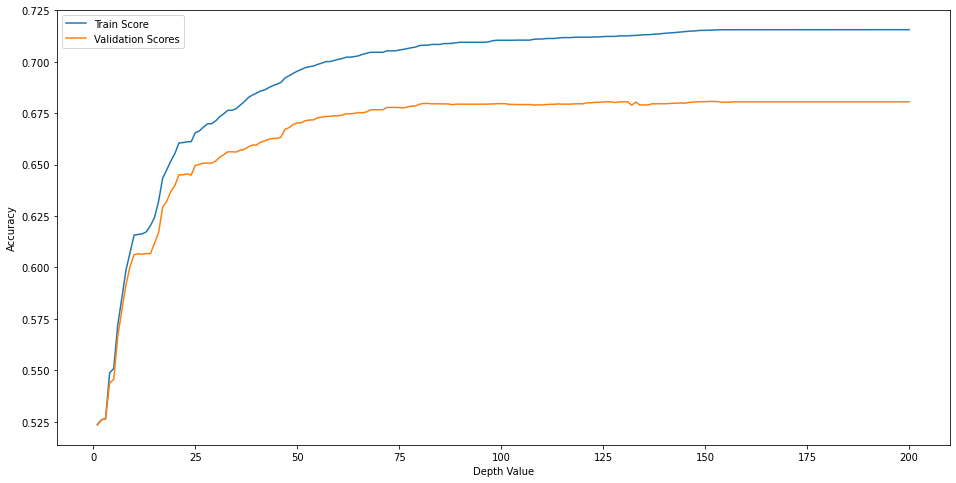

The Depth Value with the highest validation score is 151


In [44]:
plt.figure(figsize = (16,8))
plt.plot(depth_value7, trainScores7, label="Train Score")
plt.plot(depth_value7, valScores7, label="Validation Scores")
plt.xlabel('Depth Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Depth Value with the highest validation score is {bestDepthValVecDt}")

## IDF Depths

In [45]:
# Range to loop through from 1-50
depths = np.arange(1, 201)
# Empty lists to store results for graphing
trainScores71 = []
valScores71 = []
depth_value71 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores71.joblib') & 
    os.path.exists('preRunModels/valScores71.joblib') & 
    os.path.exists('preRunModels/depth_value71.joblib')):
    trainScores71 = joblib.load('preRunModels/trainScores71.joblib')
    valScores71 = joblib.load('preRunModels/valScores71.joblib')
    depth_value71 = joblib.load('preRunModels/depth_value71.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-20000....
    for depth in depths:
        # Compile, train, and fit the model and data
        dtIdf = DecisionTreeClassifier(max_depth = depth, 
                                       min_samples_leaf = bestMinValIdfDt, 
                                       random_state=12)
        dtIdf.fit(X_trainIdf, y_trainIdf)

        # Score the model predictions
        trainScores71.append(dtIdf.score(X_trainIdf, y_trainIdf))
        valScores71.append(dtIdf.score(X_valIdf, y_valIdf))
        depth_value71.append(depth)
        
        # Print the progress of the loop
        print(f"depth={depth}")
        
    # SAve teh results lists to file
    joblib.dump(trainScores71, 'preRunModels/trainScores71.joblib')
    joblib.dump(valScores71, 'preRunModels/valScores71.joblib')
    joblib.dump(depth_value71, 'preRunModels/depth_value71.joblib')
    
bestDepthValIdfDt = depth_value71[np.argmax(valScores71)]

Pre-run model will be loaded


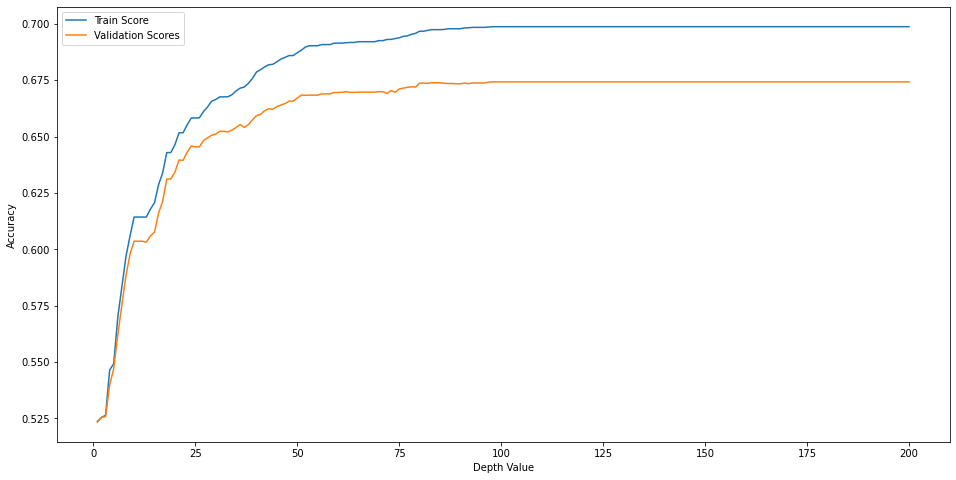

The Depth Value with the highest validation score is 98


In [46]:
plt.figure(figsize = (16,8))
plt.plot(depth_value71, trainScores71, label="Train Score")
plt.plot(depth_value71, valScores71, label="Validation Scores")
plt.xlabel('Depth Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Depth Value with the highest validation score is {bestDepthValIdfDt}")

## Decision Tree Models

In [47]:
dtVecNlp = DecisionTreeClassifier(max_depth = bestDepthValVecDt, min_samples_leaf = bestMinValVecDt, random_state=12).fit(X_trainVec, y_trainVec)
dtVecTrain = dtVecNlp.score(X_trainVec, y_trainVec)
dtVecVal = dtVecNlp.score(X_valVec, y_valVec)
print(f"Decision Tree Vec Train: {dtVecTrain}")
print(f"Decision Tree Vec Validation: {dtVecVal}")

print()

dtIdfNlp = DecisionTreeClassifier(max_depth = bestDepthValIdfDt, min_samples_leaf = bestMinValIdfDt, random_state=12).fit(X_trainIdf, y_trainIdf)
dtIdfTrain = dtIdfNlp.score(X_trainIdf, y_trainIdf)
dtIdfVal = dtIdfNlp.score(X_valIdf, y_valIdf)
print(f"Decision Tree IDF Train: {dtIdfTrain}")
print(f"Decision Tree IDF Validation: {dtIdfVal}")


Decision Tree Vec Train: 0.7153731343283583
Decision Tree Vec Validation: 0.6807272727272727

Decision Tree IDF Train: 0.6987164179104478
Decision Tree IDF Validation: 0.6742424242424242


## Multinominal Naive Bayes

In [48]:
nbVecNlp = MultinomialNB().fit(X_trainVec, y_trainVec)
nbVecTrain = nbVecNlp.score(X_trainVec, y_trainVec)
nbVecVal = nbVecNlp.score(X_valVec, y_valVec)
print(f"Multinominal Naive Bayes Vec Train: {nbVecTrain}")
print(f"Multinominal Naive Bayes Vec Validation: {nbVecVal}")

print()

nbIdfNlp = MultinomialNB().fit(X_trainIdf, y_trainIdf)
nbIdfTrain = nbIdfNlp.score(X_trainIdf, y_trainIdf)
nbIdfVal = nbIdfNlp.score(X_valIdf, y_valIdf)
print(f"Multinominal Naive Bayes Idf Train: {nbIdfTrain}")
print(f"Multinominal Naive Bayes Idf Validation: {nbIdfVal}")

Multinominal Naive Bayes Vec Train: 0.707134328358209
Multinominal Naive Bayes Vec Validation: 0.686969696969697

Multinominal Naive Bayes Idf Train: 0.7162686567164179
Multinominal Naive Bayes Idf Validation: 0.6947878787878788


In [49]:
vecModels = [
    LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12),
    SVC(C = bestCValVecSvc, random_state = 12),
    KNeighborsClassifier(n_neighbors=bestKValVecKnn),
    DecisionTreeClassifier(max_depth = bestDepthValVecDt, min_samples_leaf = bestMinValVecDt, random_state=12),
    MultinomialNB()
]

idfModels = [
    LogisticRegression(solver='lbfgs', C = bestCValIdf, random_state = 12),
    SVC(C = bestCValIdfSvc, random_state = 12),
    KNeighborsClassifier(n_neighbors=bestKValIdfKnn),
    DecisionTreeClassifier(max_depth = bestDepthValIdfDt, min_samples_leaf = bestMinValIdfDt, random_state=12),
    MultinomialNB()
]

CV = 10

cvIdfDF = pd.DataFrame(index=range(CV*len(idfModels)))
resultsIdf = []
resultsVec = []

if (os.path.exists('preRunModels/resultsIdf.joblib') & os.path.exists('preRunModels/accuraciesIdf.joblib')):
    accuraciesIdf = joblib.load('preRunModels/accuraciesIdf.joblib')
    resultsIdf = joblib.load('preRunModels/resultsIdf.joblib')
else:
    for model in idfModels:
        modelName = model.__class__.__name__
        print(modelName)
        accuraciesIdf = cross_val_score(model, X_valIdf, y_valIdf, scoring = 'accuracy', cv = CV)
        for foldIndex, accuracy in enumerate(accuraciesIdf):
            resultsIdf.append((modelName, foldIndex, accuracy))

    joblib.dump(accuraciesIdf, 'preRunModels/accuraciesIdf.joblib')
    joblib.dump(resultsIdf, 'preRunModels/resultsIdf.joblib')

cvIdfDF = pd.DataFrame(resultsIdf, columns = ['Model Name', 'Fold Index', 'Accuracy'])

if (os.path.exists('preRunModels/resultsVec.joblib') & os.path.exists('preRunModels/accuraciesVec.joblib')):
    accuraciesVec = joblib.load('preRunModels/accuraciesVec.joblib')
    resultsVec = joblib.load('preRunModels/resultsVec.joblib')
else:
    cvVecDF = pd.DataFrame(index=range(CV*len(vecModels)))
    resultsVec = []
    for model in vecModels:
        modelName = model.__class__.__name__
        print(modelName)
        accuraciesVec = cross_val_score(model, X_valVec, y_valVec, scoring = 'accuracy', cv = CV)
        for foldIndex, accuracy in enumerate(accuraciesVec):
            resultsVec.append((modelName, foldIndex, accuracy))

    joblib.dump(accuraciesVec, 'preRunModels/accuraciesVec.joblib')
    joblib.dump(resultsVec, 'preRunModels/resultsVec.joblib')

cvVecDF = pd.DataFrame(resultsVec, columns = ['Model Name', 'Fold Index', 'Accuracy'])


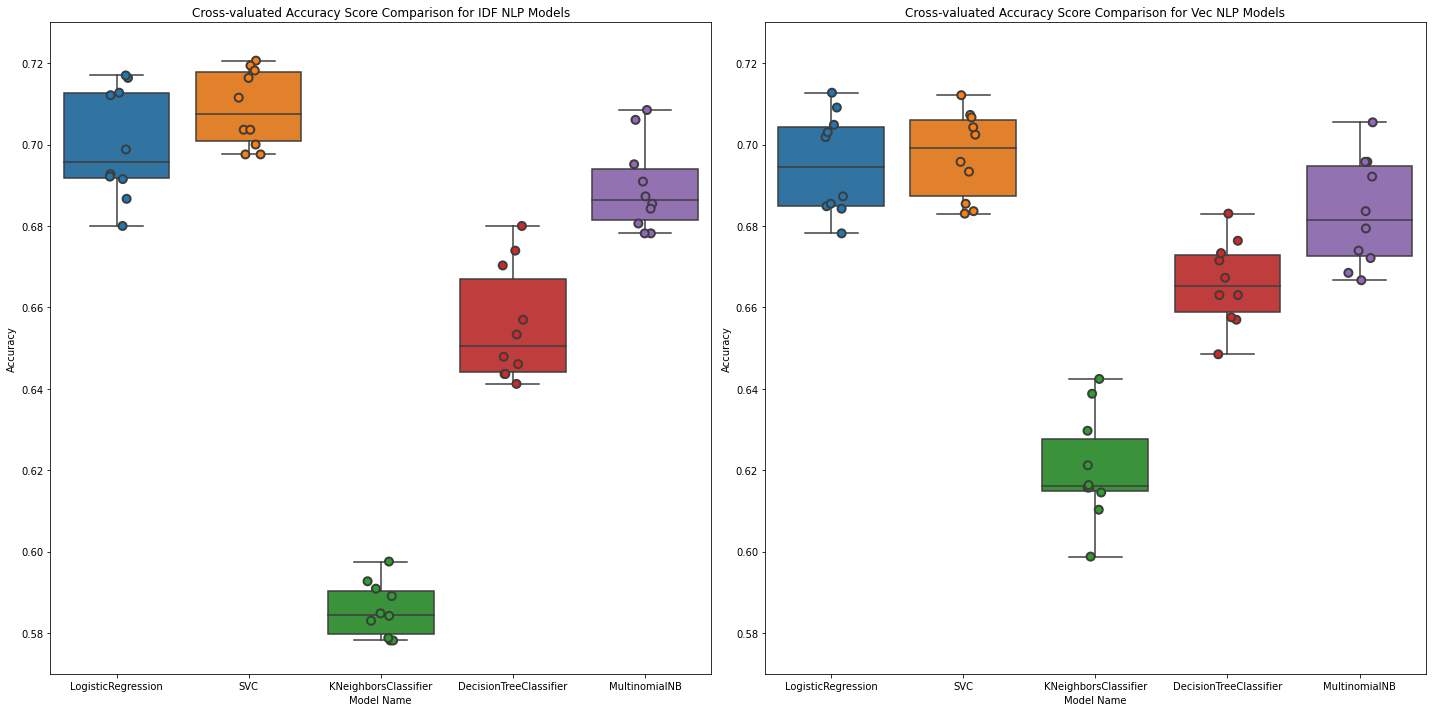

In [50]:
plt.figure(figsize = (20,10), tight_layout = True)

plt.subplot(1,2,1)
plt.title('Cross-valuated Accuracy Score Comparison for IDF NLP Models')
plt.ylim([0.57,0.73])
sns.boxplot(x='Model Name', y='Accuracy', data = cvIdfDF)
sns.stripplot(x='Model Name', y='Accuracy', data = cvIdfDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.subplot(1,2,2)
plt.title('Cross-valuated Accuracy Score Comparison for Vec NLP Models')
plt.ylim([0.57,0.73])
sns.boxplot(x='Model Name', y='Accuracy', data = cvVecDF)
sns.stripplot(x='Model Name', y='Accuracy', data = cvVecDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [51]:
tokenIdfDF = cvIdfDF.rename(columns = {'Model Name':'Tokenizer'})
tokenVecDF = cvVecDF.rename(columns = {'Model Name':'Tokenizer'})

In [52]:
logDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'LogisticRegression']
logDF.loc[logDF['Tokenizer'] == 'LogisticRegression', 'Tokenizer'] = 'Idf'
logDF = pd.concat([logDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'LogisticRegression']])
logDF.loc[logDF['Tokenizer'] == 'LogisticRegression', 'Tokenizer'] = 'Vec'

In [53]:
svcDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'SVC']
svcDF.loc[svcDF['Tokenizer'] == 'SVC', 'Tokenizer'] = 'Idf'
svcDF = pd.concat([svcDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'SVC']])
svcDF.loc[svcDF['Tokenizer'] == 'SVC', 'Tokenizer'] = 'Vec'

In [54]:
knnDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'KNeighborsClassifier']
knnDF.loc[knnDF['Tokenizer'] == 'KNeighborsClassifier', 'Tokenizer'] = 'Idf'
knnDF = pd.concat([knnDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'KNeighborsClassifier']])
knnDF.loc[knnDF['Tokenizer'] == 'KNeighborsClassifier', 'Tokenizer'] = 'Vec'

In [55]:
dtDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'DecisionTreeClassifier']
dtDF.loc[dtDF['Tokenizer'] == 'DecisionTreeClassifier', 'Tokenizer'] = 'Idf'
dtDF = pd.concat([dtDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'DecisionTreeClassifier']])
dtDF.loc[dtDF['Tokenizer'] == 'DecisionTreeClassifier', 'Tokenizer'] = 'Vec'

In [56]:
nbDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'MultinomialNB']
nbDF.loc[nbDF['Tokenizer'] == 'MultinomialNB', 'Tokenizer'] = 'Idf'
nbDF = pd.concat([nbDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'MultinomialNB']])
nbDF.loc[nbDF['Tokenizer'] == 'MultinomialNB', 'Tokenizer'] = 'Vec'

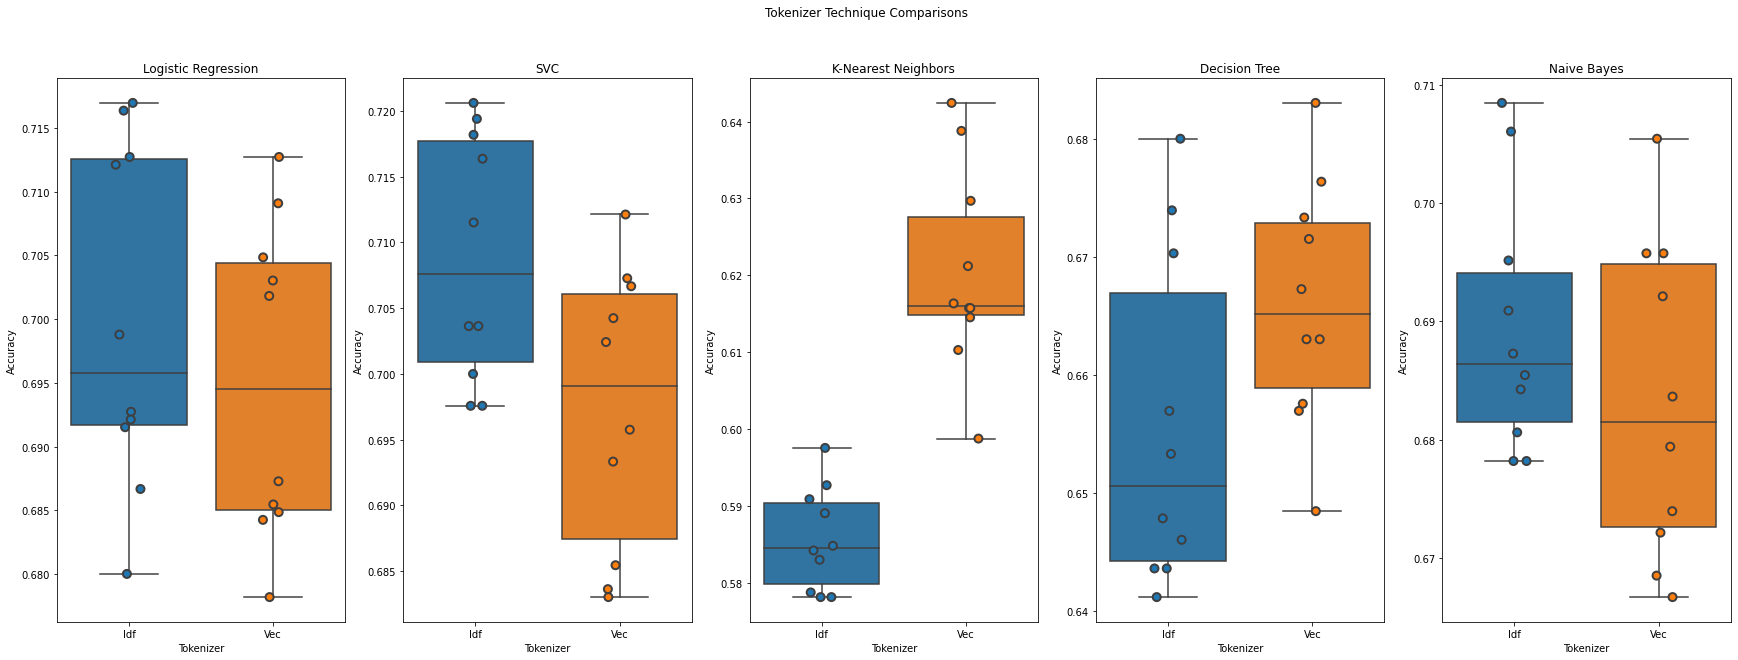

In [57]:
plt.figure(figsize = (30,10),)
plt.suptitle('Tokenizer Technique Comparisons')

plt.subplot(1,5,1)
plt.title('Logistic Regression')
sns.boxplot(x='Tokenizer', y='Accuracy', data = logDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = logDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
              
plt.subplot(1,5,2)
plt.title('SVC')
sns.boxplot(x='Tokenizer', y='Accuracy', data = svcDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = svcDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.subplot(1,5,3)
plt.title('K-Nearest Neighbors')
sns.boxplot(x='Tokenizer', y='Accuracy', data = knnDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = knnDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.subplot(1,5,4)
plt.title('Decision Tree')
sns.boxplot(x='Tokenizer', y='Accuracy', data = dtDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = dtDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.subplot(1,5,5)
plt.title('Naive Bayes')
sns.boxplot(x='Tokenizer', y='Accuracy', data = nbDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = nbDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [58]:
modelMeansDF = cvIdfDF.groupby('Model Name', as_index = False).Accuracy.mean()
tempVecDF = cvVecDF.groupby('Model Name', as_index = False).Accuracy.mean()
modelMeansDF.merge(tempVecDF, 'inner', on = 'Model Name', suffixes = (' Mean IDF', ' Mean Vec'))

,Model Name,Accuracy Mean IDF,Accuracy Mean Vec
0,DecisionTreeClassifier,0.655697,0.666061
1,KNeighborsClassifier,0.585758,0.620364
2,LogisticRegression,0.700000,0.695152
3,MultinomialNB,0.689455,0.683333
4,SVC,0.708848,0.697394


In [59]:
svcIdfPreds = svcIdfNlp.predict(X_valIdf)
logVecPreds = logitVec.predict(X_valVec)

In [60]:
print(metrics.classification_report(y_valIdf, svcIdfPreds, target_names = sentTrain['sentiment'].unique()))
print(metrics.classification_report(y_valVec, logVecPreds, target_names = sentTrain['sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.69      0.72      0.71      4649
    negative       0.51      0.28      0.37      3215
     neutral       0.78      0.89      0.83      8636

    accuracy                           0.73     16500
   macro avg       0.66      0.63      0.63     16500
weighted avg       0.70      0.73      0.71     16500

              precision    recall  f1-score   support

    positive       0.68      0.70      0.69      4649
    negative       0.43      0.18      0.25      3215
     neutral       0.75      0.90      0.82      8636

    accuracy                           0.70     16500
   macro avg       0.62      0.59      0.59     16500
weighted avg       0.67      0.70      0.67     16500



In [61]:
binarySentTrain = sentTrain.copy()
binarySentTrain['sentiment'].replace({'neutral':'non-positive', 'negative':'non-positive'}, inplace = True)
binarySentTrain['label'].replace({1:0, 2:1}, inplace = True)
binarySentTrain

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,1
1,positive,Overall in hand ecpirience is quite good matt ...,1
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",1
3,positive,Bigger size of application names doesn't allow...,1
4,non-positive,Just a hype of stock android which is not flaw...,0
...,...,...,...
49995,positive,good display..good battery...awsm perfomace..i...,1
49996,non-positive,bad phone,0
49997,non-positive,Fingerprint does not work properly,0
49998,non-positive,Bakbass phone ever. Camera quality just 2 mp c...,0


In [62]:
XBinary = binarySentTrain['text']
yBinary = binarySentTrain['label']

XBinaryIdf = sentWordsIdf.fit_transform(XBinary)
XBinaryVec = sentWordsVec.fit_transform(XBinary)

XBIdfTrain, XBIdfVal, yBIdfTrain, yBIdfVal = train_test_split(XBinaryIdf, yBinary, test_size = 0.33, random_state = 12)
XBVecTrain, XBVecVal, yBVecTrain, yBVecVal = train_test_split(XBinaryVec, yBinary, test_size = 0.33, random_state = 12)

svcBIdfNlp = SVC(C = bestCValIdfSvc, random_state = 12)
svcBIdfNlp.fit(XBIdfTrain, yBIdfTrain)
svcBIdfPreds = svcBIdfNlp.predict(XBIdfVal)

logitBVec = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)
logitBVec.fit(XBVecTrain, yBVecTrain)
logBVecPreds = logitBVec.predict(XBVecVal)

print(metrics.classification_report(yBIdfVal, svcBIdfPreds, target_names = binarySentTrain['sentiment'].unique()))
print(metrics.classification_report(yBVecVal, logBVecPreds, target_names = binarySentTrain['sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.82      0.81      0.82      7864
non-positive       0.83      0.83      0.83      8636

    accuracy                           0.82     16500
   macro avg       0.82      0.82      0.82     16500
weighted avg       0.82      0.82      0.82     16500

              precision    recall  f1-score   support

    positive       0.80      0.81      0.80      7864
non-positive       0.83      0.81      0.82      8636

    accuracy                           0.81     16500
   macro avg       0.81      0.81      0.81     16500
weighted avg       0.81      0.81      0.81     16500



In [63]:
dropSentTrain = sentTrain[sentTrain.sentiment != 'neutral']
dropSentTrain['label'].replace({2:1}, inplace = True)
dropSentTrain

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,1
1,positive,Overall in hand ecpirience is quite good matt ...,1
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",1
3,positive,Bigger size of application names doesn't allow...,1
4,negative,Just a hype of stock android which is not flaw...,0
...,...,...,...
49994,positive,This place is heavenly!!! I have dreams about ...,1
49995,positive,good display..good battery...awsm perfomace..i...,1
49996,negative,bad phone,0
49998,negative,Bakbass phone ever. Camera quality just 2 mp c...,0


In [64]:
XDrop = dropSentTrain['text']
yDrop = dropSentTrain['label']

XDropIdf = sentWordsIdf.fit_transform(XDrop)
XDropVec = sentWordsVec.fit_transform(XDrop)

XDIdfTrain, XDIdfVal, yDIdfTrain, yDIdfVal = train_test_split(XDropIdf, yDrop, test_size = 0.33, random_state = 12)
XDVecTrain, XDVecVal, yDVecTrain, yDVecVal = train_test_split(XDropVec, yDrop, test_size = 0.33, random_state = 12)

svcDIdfNlp = SVC(C = bestCValIdfSvc, random_state = 12)
svcDIdfNlp.fit(XDIdfTrain, yDIdfTrain)
svcBIdfPreds = svcDIdfNlp.predict(XDIdfVal)

logitDVec = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)
logitDVec.fit(XDVecTrain, yDVecTrain)
logBVecPreds = logitDVec.predict(XDVecVal)

print(metrics.classification_report(yDIdfVal, svcBIdfPreds, target_names = dropSentTrain['sentiment'].unique()))
print(metrics.classification_report(yDVecVal, logBVecPreds, target_names = dropSentTrain['sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.84      0.79      0.81      4631
    negative       0.89      0.92      0.91      8683

    accuracy                           0.87     13314
   macro avg       0.87      0.85      0.86     13314
weighted avg       0.87      0.87      0.87     13314

              precision    recall  f1-score   support

    positive       0.85      0.74      0.79      4631
    negative       0.87      0.93      0.90      8683

    accuracy                           0.87     13314
   macro avg       0.86      0.84      0.85     13314
weighted avg       0.86      0.87      0.86     13314



In [67]:
def predictText(csvFilePath, outputFileName):
    dropSentTest = pd.read_csv(csvFilePath)

    idToCategory = {0: 'negative', 1: 'positive'}

    testText = dropSentTest.to_numpy().ravel()
    sentWordsIdf.fit(XDrop)
    testTextTokens = sentWordsIdf.transform(testText).toarray()
    testPreds = svcDIdfNlp.predict(testTextTokens)

    todayDate = date.today().strftime('%Y%m%d')
    predDoc = open(outputFileName+".txt", "a", encoding = "utf-8")
    predDoc.write(f"Beginning of "+todayDate+" reviews"+"\n")
    for text, predicted in zip(testText, testPreds):
        predDoc.write('"{}"'.format(text)+"\n")
        predDoc.write("  - Predicted as: '{}'".format(idToCategory[predicted])+"\n")
        predDoc.write("---------------------------------------------------------------------------------------\n")
    predDoc.write(f"End of "+todayDate+" reviews\n")
    predDoc.close()

    predValues, predCounts = np.unique(testPreds, return_counts = True)
    plt.figure(figsize = (16,8))
    plt.pie(predCounts, explode = (0, 0.05), labels = ['Negative', 'Positive'], autopct='%1.1f%%', radius = 3, labeldistance = -0.5, textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
    plt.show()

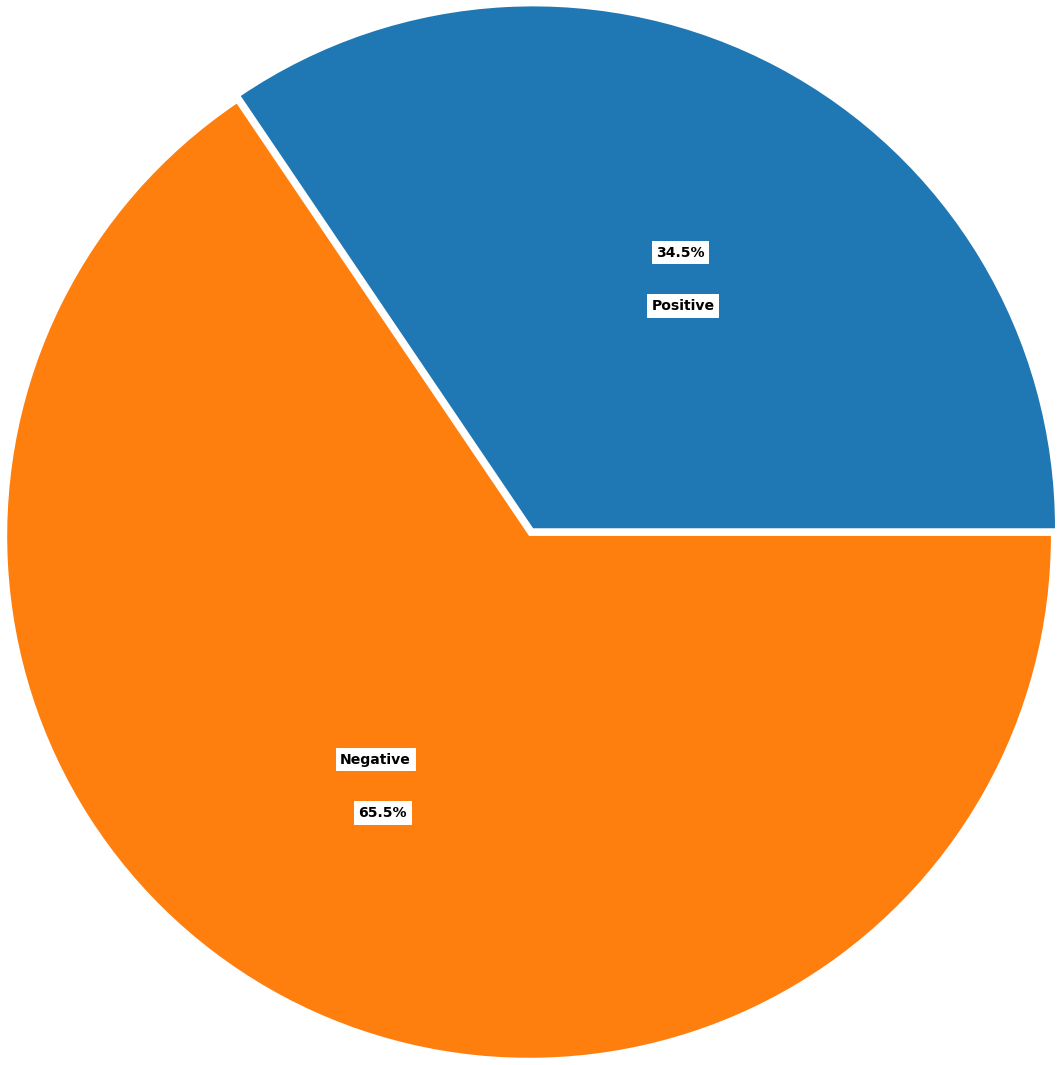

In [68]:
predictText('testTextData.csv','reviewMasterList')